# 1. Data Collection


## 1.1 Install libraries

## 1.2 GTZAN dataset
The `GTZAN dataset` is the most-used public dataset for evaluation in machine listening research for music genre recognition (MGR). The files were collected in 2000-2001 from a variety of sources including personal CDs, radio, microphone recordings. The format of the files were `.wavs`, so I was able to use the librosa library to read them into the notebook.

The labels are 10 GTZAN music genres 

# 2.Data Pre-processing

In [48]:
# create a csv file that maps images to audio labels
#!chmod +x Data/GZTAN/create_csv.sh && ./Data/GZTAN/create_csv.sh ./Data/GZTAN/genres_original

mapping files in directory: ./Data/GZTAN/genres_original
blues: 100
classical: 100
country: 100
disco: 100
hiphop: 100
jazz: 99
metal: 100
pop: 100
reggae: 100
rock: 100


## 2.1 Audio Sampling
Audio sampling is the process of converting an audio signal into a digital representation by periodically measuring the amplitude of the audio signal. The number of samples per second is called the sample rate (sr), and a higher sample rate means that more samples are captured per second, resulting in better audio quality.

## Torchaudio

`Torchaudio` is a library for audio and signal processing with PyTorch. It provides I/O, signal and data processing functions, datasets, model implementations and application components.

 First, we use `librosa` to load the audio. The `librosa.load` function loads an audio file located at the specified path and returns the audio data as a numpy array and the sample rate as an integer.

In [8]:
import librosa
import librosa.display
import IPython.display as ipd

# test the dataset
audio ="Data/GZTAN/genres_original/rock/rock.00002.wav"
test_data,sr=librosa.load(audio)
print(type(test_data),type(sr))
print(f"There are {test_data.shape[0]} sampling points in this audio.")
print(f"The sampling rate is {sr}.")

<class 'numpy.ndarray'> <class 'int'>
There are 661794 sampling points in this audio.
The sampling rate is 22050.


IPython.display is a module that provides functions for displaying various types of media. We can use `ipd.Audio() `function to display an audio file. Here I select one of the samples from the GTZAN database as test_data

Now I can play this music clip using `Ipd.Audio`

In [9]:
ipd.Audio(audio)

## 2.2 Log-Mel Feature Extraction

`Spectrograms` are a way to visually represent a signal's loudness, or amplitude, as it varies over time at different frequencies. The horizontal axis is time, the vertical axis is frequency, and the color is amplitude. It is calculated using the `fast Fourier transform` on short time windows of the signal and transforming the vertical axis (frequency) to log scale and the colored axis (amplitude) to decibals.

The `Log-Mel spectrum` is based on the Mel scale, which is a logarithmic scale that is used to represent the frequency of sound in a way that is more closely aligned with the human auditory system.

We can use function `librosa.feature.melspectrogram()` to extract the Mel spectrum and use function `librosa.power_to_db`() to execute logarithmic operations.

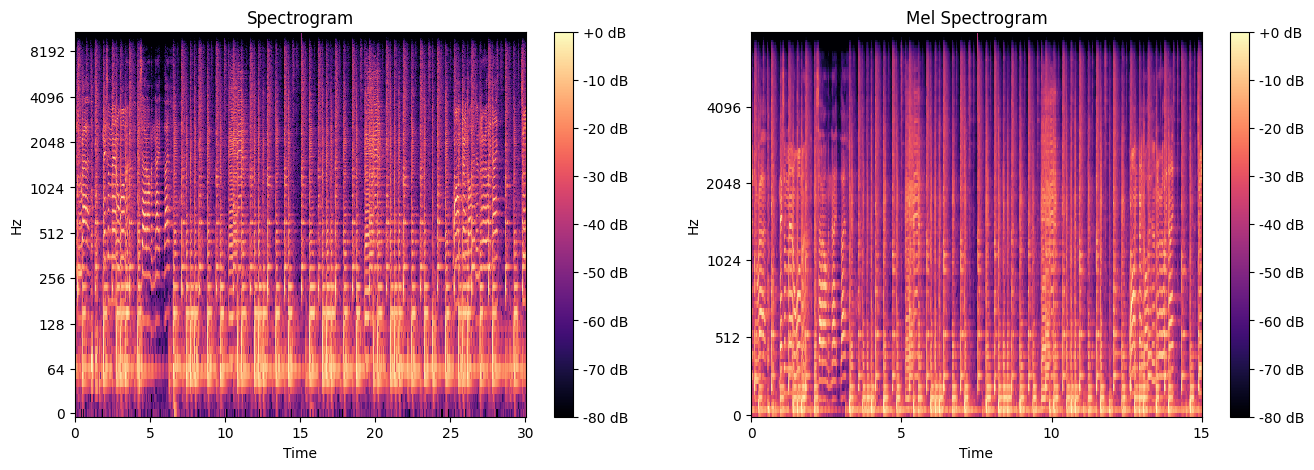

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Computing the spectrogram
spec_1 = np.abs(librosa.stft(test_data, hop_length=512))
spec_1 = librosa.amplitude_to_db(spec_1, ref=np.max) # converting to decibals
# Computing the mel spectrogram
spec_2 = librosa.feature.melspectrogram(y=test_data, sr=sr, n_fft=2048, hop_length=1024)
spec_2 = librosa.power_to_db(spec_2, ref=np.max) # Converting to decibals

# Plotting the spectrogram
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
librosa.display.specshow(spec_1, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Plotting the mel spectrogram
plt.subplot(1,2,2)
librosa.display.specshow(spec_2, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')


# 3. Data Loading

In the project, the dataset I downloaded has both .wav files and image file, so let's skip the process of extracting the Mel spectrum from audio, and start mapping .wav files to their mel spectrum images.

## 3.1 Subclassing the Dataset class

By subclassing the Dataset class, we can create a custom dataset object that is passed to `PyTorch`'s DataLoader. This is useful when the dataset is not built into `PyTorch`, or if there is a custom dataset that requires pre-processing or additional functionality. I have organised the series of data pre-processing steps above in the subclass `GTZANDataset`. 
For the time being we will only use the original data without data augmentation for training, later I will use data augmentation techniques to compare with the current results.

I created a module called Dataloader, which contains a subclass of the data preprocess function `wavs_to_spectrogram`, Dataset class `GTZANDataset` the collate function `custom_collate_fn` and the `load_data` function to split the data.

In [1]:
import importlib
import DataLoader 
importlib.reload(DataLoader)
from DataLoader import*
import matplotlib.pyplot as plt


In [49]:
i = wavs_to_spectrogram("Data/GZTAN/genres_original/jazz/jazz.00055.wav")
i.shape

torch.Size([1, 128, 1293])

In [2]:
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=16)

### 3.3  Visualising image data

We can visualize several spectrograms to check if the data is randomly split.

torch.Size([1, 128, 1000])
torch.Size([1, 128, 1000])
torch.Size([1, 128, 1000])
torch.Size([1, 128, 1000])
torch.Size([1, 128, 1000])
torch.Size([1, 128, 1000])


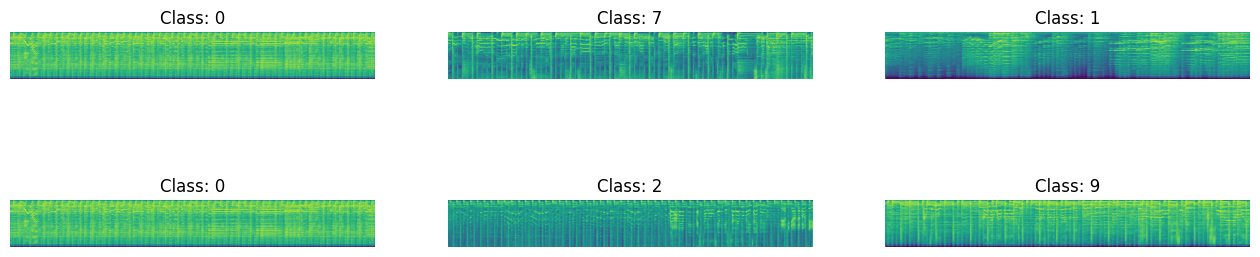

In [3]:
plt.figure(figsize=[16, 4])
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.axis("off")
    
    # get a batch data
    batch = next(iter(train_dl))
    print(batch[0][0].shape)
    image = batch[0][0].permute(1, 2, 0)
    label = batch[1][0].item()  # transfer PyTorch Tensor to Python scalar
    
    plt.imshow(image)
    plt.title(f"Class: {label}")


# 4. Classification


## 4.1 2D CNN
For this part, I learned from the code from `https://music-classification.github.io/tutorial/part3_supervised/tutorial.htmland`, and I used the CNN part of this code to get better results.

This simple 2D CNN model consists of 3x3 convolution, batch normalization, ReLU non-linearity, and 2x2 max pooling. This module is going to be used for each layer of the 2D CNN.The Conv_2d class represents a generic 2D convolutional layer.

In [4]:
import CNNClassifier
importlib.reload(CNNClassifier)
from CNNClassifier import*

In [45]:
from torchsummary import summary
summary(CNNClassifier(), input_size=(1, 128, 1000), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 16, 128, 1000]             160
              ReLU-2        [-1, 16, 128, 1000]               0
         MaxPool2d-3          [-1, 16, 64, 500]               0
            Conv2d-4          [-1, 32, 64, 500]           4,640
              ReLU-5          [-1, 32, 64, 500]               0
         MaxPool2d-6          [-1, 32, 32, 250]               0
            Conv2d-7          [-1, 64, 32, 250]          18,496
              ReLU-8          [-1, 64, 32, 250]               0
         MaxPool2d-9          [-1, 64, 16, 125]               0
           Linear-10                  [-1, 128]      16,384,128
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 16,408,714
Trainable params: 16,408,714
Non-trainable params: 0
-------------------------

## 4.2 Device
In this project, I set the device to GPU (i.e. Cuda), in order to speed up the training.

In [5]:
import torch

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

## 4.3 ExponentialLR
`ExponentialLR` reduces the learning rate at each step by a factor of `gamma`. The learning rate is first initialised and then at each step the learning rate is multiplied by `gamma`. it is defined in `torch.optim.lr_scheduler` and is usually used in combination with an `optimiser`.

In [6]:
from torch.optim.lr_scheduler import ExponentialLR

## 4.4 Early Stopping
Early stopping is used to prevent overfitting of models. Once a specified limit is reached, the training process is stopped so that the model is not over-trained on the training data. In this project, I defined an `EarlyStopper` module and set the corresponding `patience` and `tolerance`. `patience` refers to the number of unraised times that can be tolerated, and `tolerance` refers to the value of unraised correctness that can be tolerated.

In [7]:
import EarlyStopper
importlib.reload(EarlyStopper)
from EarlyStopper import *

## 4.5 Logging
We can use the `SummaryWriter` class in the `torch.utils.tensorboard` module to record data from training to the TensorBoard, and can start a web server and view the recorded data in a web browser by typing TensorBoard-related commands `tensorboard --logdir=runs/` in the terminal.

In [8]:
from torch.utils.tensorboard import SummaryWriter

2024-01-21 13:34:37.668829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-21 13:34:37.688516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 13:34:37.688543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 13:34:37.689072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 13:34:37.692631: I tensorflow/core/platform/cpu_feature_guar

## 4.6 Checkpointing
Checkpoints allows the parameters of the model to be periodically saved to a file and then loaded into the model when training is resumed. This is useful in cases where training is interrupted or where we want to save the state of the model at a certain point in training for later use.

In [9]:
import Checkpointing
importlib.reload(Checkpointing)
from Checkpointing import *

## 4.7 Training Loop
I use the `train` function and the `val` function in the module `TrainAndVal` to train the simple CNN module.

In [43]:
import TrainAndVal
importlib.reload(TrainAndVal)

<module 'TrainAndVal' from '/home/s5614279/Desktop/github/MusicClassificaitonProject-SoftwareEngineering/TrainAndVal.py'>

In [58]:
from torchmetrics import Accuracy
from tqdm.auto import tqdm

# Seed for setting the CUDA random number generator to ensure reproducible results when computing with CUDA
torch.cuda.manual_seed(30)

epochs = 100
checkpoint_frequency=3
learning_rate = 0.01

network = CNNClassifier()
acc_fn = Accuracy(task="multiclass", num_classes=10).to(DEVICE)
loss_fn =  nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=network.parameters(),lr=learning_rate)
schd = ExponentialLR(optimizer,gamma=1)
stopper =  EarlyStopper(patience=10, tolerance=0.1)
writer = SummaryWriter()

network = network.to(DEVICE)

for epoch in tqdm(range(epochs)): # show the process
  
    print(f"Epoch: {epoch}\n-------")

    TrainAndVal.train(epochs=epoch,
            model = network,
            train_dl = train_dl, 
            optimizer = optimizer,
            lr_scheduler = schd,
            acc_fn = acc_fn,
            loss_fn = loss_fn,
            writer = writer,
            DEVICE = DEVICE
            )

    if (epoch % checkpoint_frequency == 0):
        Checkpointing.save_checkpoint(model=network,epoch=epoch, save_dir="./saved_models" )

    if (TrainAndVal.val(epochs=epoch, model=network,val_dl=val_dl, early_stopper=stopper, acc_fn=acc_fn, loss_fn=loss_fn, writer=writer, DEVICE=DEVICE)==0):
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 2.20238 | Train acc: 0.18% | LR: 0.01000
Validation loss: 2.01257 | Validation acc: 0.28

Epoch: 1
-------
Train loss: 2.01194 | Train acc: 0.27% | LR: 0.01000
Validation loss: 2.20711 | Validation acc: 0.15

Epochs without improvement: 1

Epoch: 2
-------
Train loss: 1.90210 | Train acc: 0.28% | LR: 0.01000
Validation loss: 1.87590 | Validation acc: 0.32

Epoch: 3
-------
Train loss: 1.77279 | Train acc: 0.35% | LR: 0.01000
Validation loss: 1.83536 | Validation acc: 0.38

Epoch: 4
-------
Train loss: 1.65908 | Train acc: 0.40% | LR: 0.01000
Validation loss: 1.81136 | Validation acc: 0.38

Epoch: 5
-------
Train loss: 1.57897 | Train acc: 0.43% | LR: 0.01000
Validation loss: 1.71970 | Validation acc: 0.38

Epoch: 6
-------
Train loss: 1.43344 | Train acc: 0.46% | LR: 0.01000
Validation loss: 1.55984 | Validation acc: 0.45

Epoch: 7
-------
Train loss: 1.26500 | Train acc: 0.56% | LR: 0.01000
Validation loss: 2.34398 | Validation acc: 0.25

Epochs without im

## 4.8 ResNet Model
As we can see from the training process above, the CNN model is very prone to gradient disappearance, which is a common problem with CNN models. To address this problem, the researchers proposed the `ResNet (Residual Network)` model, whose innovation is the use of residual connectivity, which allows the network to bypass one or more layers and propagate the input directly to deeper layers. This allows the network to go much deeper than a traditional CNN without suffering from the gradient disappearance problem. The architecture of ResNet model can be viewed in file `ResNet.py.`

In [11]:
import ResNet
importlib.reload(ResNet)

<module 'ResNet' from '/home/s5614279/Desktop/github/MusicClassificaitonProject-SoftwareEngineering/ResNet.py'>

In [124]:
from torchmetrics import Accuracy
import torch.nn as nn
from tqdm.auto import tqdm

torch.cuda.manual_seed(30)

epochs = 50 # According to the CNN model, 50 epoches are quite enough
batch_sz = 16
checkpoint_frequency = 3
learning_rate = 0.01

# data loading with new batch size
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)

torch.autograd.set_detect_anomaly(True)

# Instatiate network and send to device
ResNet_network = ResNet.get_resnet().to(DEVICE)
acc_fn = Accuracy(task="multiclass", num_classes=10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=ResNet_network.parameters(), lr=learning_rate)
schd = ExponentialLR(optimizer,gamma=1)
stopper =  EarlyStopper(patience=5, tolerance=0.1)
writer = SummaryWriter()

for epoch in tqdm(range(epochs)):

    print(f"Epoch: {epoch}\n-------")

    TrainAndVal.train_part(epochs=epoch,
            model = ResNet_network,
            train_dl = train_dl, 
            optimizer = optimizer,
            lr_scheduler = schd,
            acc_fn = acc_fn,
            loss_fn = loss_fn,
            writer = writer,
            DEVICE = DEVICE
            )

    if (epoch % checkpoint_frequency == 0):
        Checkpointing.ResNet_save_checkpoint(model=ResNet_network,epoch=epoch, save_dir="./saved_models" )

    if (TrainAndVal.val_part(epochs=epoch, model=ResNet_network, val_dl=val_dl, early_stopper=stopper, acc_fn=acc_fn, loss_fn=loss_fn, writer=writer, DEVICE=DEVICE) == 0):
        break

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.97434 | Train acc: 0.30% | LR: 0.01000
Validation loss: 1.90570 | Validation acc: 0.33

Epoch: 1
-------
Train loss: 1.38633 | Train acc: 0.49% | LR: 0.01000
Validation loss: 1.77500 | Validation acc: 0.38

Epoch: 2
-------
Train loss: 1.20435 | Train acc: 0.57% | LR: 0.01000
Validation loss: 1.65871 | Validation acc: 0.47

Epoch: 3
-------
Train loss: 0.95069 | Train acc: 0.67% | LR: 0.01000
Validation loss: 1.54370 | Validation acc: 0.49

Epoch: 4
-------
Train loss: 0.87581 | Train acc: 0.68% | LR: 0.01000
Validation loss: 2.84131 | Validation acc: 0.38

Epochs without improvement: 1

Epoch: 5
-------
Train loss: 0.70942 | Train acc: 0.75% | LR: 0.01000
Validation loss: 0.97441 | Validation acc: 0.67

Epoch: 6
-------
Train loss: 0.54628 | Train acc: 0.81% | LR: 0.01000
Validation loss: 2.07296 | Validation acc: 0.50

Epochs without improvement: 1

Epoch: 7
-------
Train loss: 0.46974 | Train acc: 0.83% | LR: 0.01000
Validation loss: 1.25138 | Validati

## 4.9 Deployment
Now we are satisfied with this trained model, we can load it from the latest checkpoint that has been saved. The exact number will depend on when the training was stopped so please check this in `saved_models` directory before loading.

In [12]:
ResNet_best_epoch = 27
ResNet_loaded_net = torch.load(f"saved_models/ResNet_checkpoint_{ResNet_best_epoch}.pt")

# 5. Testing/Inference
Now the training is done, we can then use the test data split to see how the model does against it. First, we define a testing function (this is identical to the validation routine in our training function. We're just using this as a substitute for deployment.)

In [18]:
import Test
importlib.reload(Test)

<module 'Test' from '/home/s5614279/Desktop/github/MusicClassificaitonProject-SoftwareEngineering/Test.py'>

In [19]:
#model = ResNet.get_resnet()
#model = model.to(DEVICE)
#TestModel = model.load_state_dict(ResNet_loaded_net)
TestModel = ResNet_loaded_net.to(DEVICE)

Test.test_model(model=TestModel, test_dl=test_dl, DEVICE=DEVICE)

Testing batch[10/13]
Final test accuracy for 200 examples: 94.00000


# 6. Confusion Matrix
we can assess the performance and visualize a confusion matrix for better understanding.  I use the ConfusionMatrix module to draw the matrix.

In [26]:
import ConfusionMatrix
importlib.reload(ConfusionMatrix)

<module 'ConfusionMatrix' from '/home/s5614279/Desktop/github/MusicClassificaitonProject-SoftwareEngineering/ConfusionMatrix.py'>

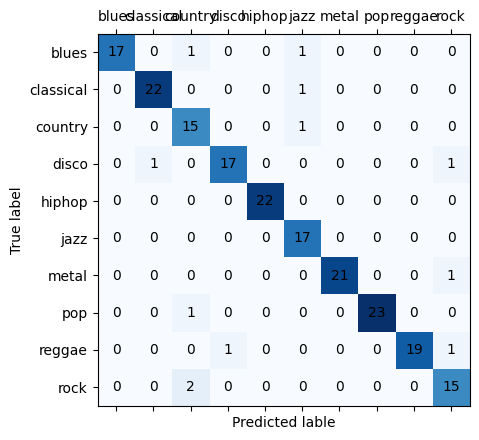

In [27]:
ConfusionMatrix.ConfusionMatrix(model=ResNet_loaded_net, dataloader=test_dl, DEVICE=DEVICE)

# 7. TDD and Unit Test

In [34]:
!pip install pytest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 11.2 MB/s eta 0:00:00


In [1]:
!pytest

============================= test session starts ==============================
platform linux -- Python 3.11.5, pytest-7.4.4, pluggy-1.3.0
rootdir: /home/s5614279/Desktop/github/aseassignment2021-22-FangLingxiao
plugins: anyio-4.0.0
collected 5 items                                                              

test_module.py .....                                                     [100%]

=============================== warnings summary ===============================
../../../miniconda3/envs/sem-deep-learning/lib/python3.11/site-packages/lightning_utilities/core/imports.py:13
  /home/s5614279/miniconda3/envs/sem-deep-learning/lib/python3.11/site-packages/lightning_utilities/core/imports.py:13: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
    import pkg_resources

../../../miniconda3/envs/sem-deep-learning/lib/python3.11/site-packages/pkg_resources/__init__.py:2871
  /home/s5614279/miniconda3/envs/sem-deep-l